In [1]:
import numpy as np
import pandas as pd
import healpy as hp
import pyccl as ccl
import pylab as plt
import math
from glob import glob

In [2]:
!which python

/home/akira.tokiwa/.conda/envs/lssc/bin/python


In [3]:
ccl.__version__

'2.1.0'

In [3]:
total_sky_area_deg2 = 4 * np.pi * (180/np.pi)**2

def dimensionless_cov(cov, ell):
    return cov * ell[:, None] * (ell[:, None] + 1) * ell[None, :] * (ell[None, :] + 1) / (2 * np.pi)**2
    
def dimensionless_cl(cl, ell):
    return cl * ell * (ell + 1) / (2 * np.pi)

In [4]:
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, sigma8=0.8, n_s=0.96, 
                      Neff=0,m_nu=0,Omega_k=0,transfer_function='eisenstein_hu')

mass_def = ccl.halos.MassDef('vir', 'matter')
hmf = ccl.halos.MassFuncSheth99(mass_def=mass_def,mass_def_strict=False,use_delta_c_fit=True)
hbf = ccl.halos.HaloBiasSheth99(mass_def=mass_def,mass_def_strict=False)
cM = ccl.halos.ConcentrationDuffy08(mass_def=mass_def)
prf = ccl.halos.HaloProfileNFW(mass_def=mass_def, concentration=cM)
hmc = ccl.halos.HMCalculator(mass_function=hmf, halo_bias=hbf,mass_def=mass_def)

TypeError: __init__() missing 1 required positional argument: 'cosmo'

<>:19: SyntaxWarning: invalid escape sequence '\q'
<>:20: SyntaxWarning: invalid escape sequence '\q'
<>:19: SyntaxWarning: invalid escape sequence '\q'
<>:20: SyntaxWarning: invalid escape sequence '\q'
/var/folders/0d/8g1xn5h16zsbw0q1yz0mr9dr0000gn/T/ipykernel_80256/1485993554.py:19: SyntaxWarning: invalid escape sequence '\q'
  plt.xlabel('$k\quad[Mpc^{-1}]$', fontsize = 22)
/var/folders/0d/8g1xn5h16zsbw0q1yz0mr9dr0000gn/T/ipykernel_80256/1485993554.py:20: SyntaxWarning: invalid escape sequence '\q'
  plt.ylabel('$P(k)\quad[{\\rm Mpc}]^3$', fontsize=22)


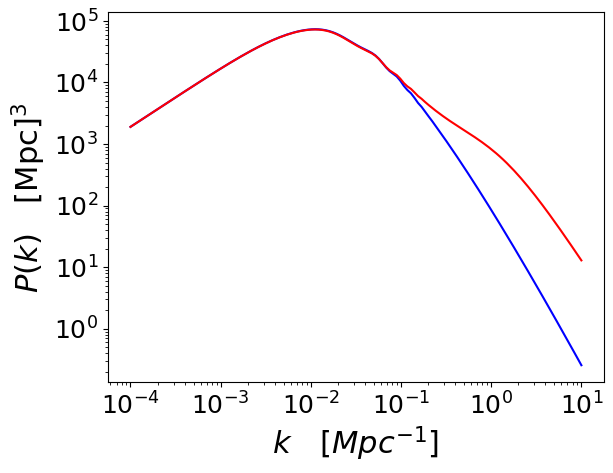

In [30]:
# Wavenumber
kmin=1e-4
kmax=1e1
nk=128
k = np.logspace(np.log10(kmin), np.log10(kmax), nk) 

# Scale factor
a = 1. 

# Calculate different P(k)
pk_lin = ccl.linear_matter_power(cosmo, k, a)
pk_nl = ccl.nonlin_matter_power(cosmo, k, a)

plt.plot(k, pk_lin, 'b-')
plt.plot(k, pk_nl, 'r-')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$k\quad[Mpc^{-1}]$', fontsize = 22)
plt.ylabel('$P(k)\quad[{\\rm Mpc}]^3$', fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show()

In [47]:
import pyccl as ccl
import numpy as np
import matplotlib.pyplot as plt
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, n_s=0.96, sigma8=0.8)

<>:13: SyntaxWarning: invalid escape sequence '\q'
<>:14: SyntaxWarning: invalid escape sequence '\q'
<>:13: SyntaxWarning: invalid escape sequence '\q'
<>:14: SyntaxWarning: invalid escape sequence '\q'
/var/folders/0d/8g1xn5h16zsbw0q1yz0mr9dr0000gn/T/ipykernel_80256/2462785284.py:13: SyntaxWarning: invalid escape sequence '\q'
  plt.ylabel('$G(k)\quad[]$', fontsize=22)
/var/folders/0d/8g1xn5h16zsbw0q1yz0mr9dr0000gn/T/ipykernel_80256/2462785284.py:14: SyntaxWarning: invalid escape sequence '\q'
  plt.xlabel('$k\quad[Mpc^{-1}]$', fontsize=22)


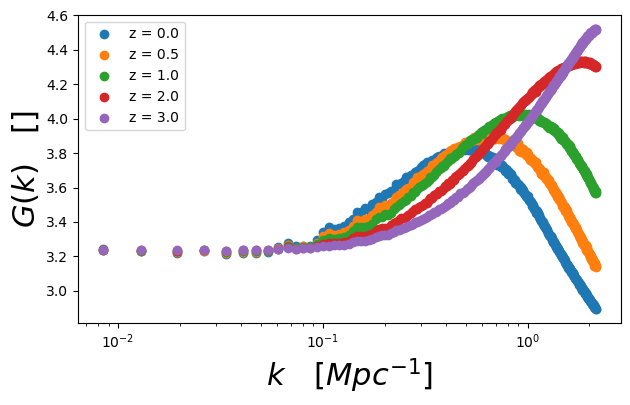

In [48]:

# Step 0: Load data
storage_dir = '/Users/akiratokiwa/Downloads/'
k_h_data = np.loadtxt(f'{storage_dir}/G_1_k_h.tab', usecols=[0]) * cosmo['h']
z_data = np.loadtxt(f'{storage_dir}/G_1_z.tab', usecols=[0])
vals_data = np.loadtxt(f'{storage_dir}/G_1_vals.tab', usecols=[0]).reshape(k_h_data.shape[0], z_data.shape[0])


fig = plt.figure(figsize=(7, 4))
for i in range(len(z_data)):
    plt.scatter(k_h_data, vals_data[:, i]+2, label='z = '+str(z_data[i]))

plt.xscale('log')
plt.ylabel('$G(k)\quad[]$', fontsize=22)
plt.xlabel('$k\quad[Mpc^{-1}]$', fontsize=22)
plt.legend()
plt.show()

<>:14: SyntaxWarning: invalid escape sequence '\q'
<>:15: SyntaxWarning: invalid escape sequence '\q'
<>:14: SyntaxWarning: invalid escape sequence '\q'
<>:15: SyntaxWarning: invalid escape sequence '\q'
/var/folders/0d/8g1xn5h16zsbw0q1yz0mr9dr0000gn/T/ipykernel_80256/130211461.py:14: SyntaxWarning: invalid escape sequence '\q'
  plt.xlabel('$k\quad[Mpc^{-1}]$', fontsize=22)
/var/folders/0d/8g1xn5h16zsbw0q1yz0mr9dr0000gn/T/ipykernel_80256/130211461.py:15: SyntaxWarning: invalid escape sequence '\q'
  plt.ylabel('$G_1(k)P(k)\quad[]$', fontsize=22)


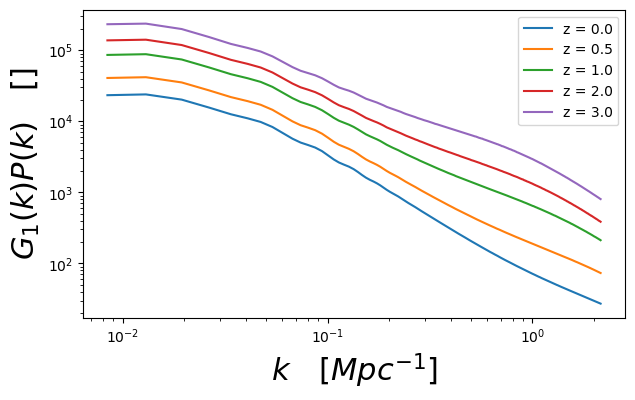

In [49]:

# Step 1: Preprocess data
vals_data+= 2 
a_arr = 1 / (1 + z_data[::-1])  # Scale factor array
lk_arr = np.log(k_h_data)  # Log of k array for Tk3D
pk_arr = np.zeros((len(a_arr), len(lk_arr)))  # Shape (a, k)
for i in range(len(z_data)):
    pk_arr[i] = ccl.nonlin_matter_power(cosmo, k_h_data, a_arr[i]) * (vals_data[:, -(i+1)])

fig = plt.figure(figsize=(7, 4))
for i, z in enumerate(z_data):
    plt.plot(k_h_data, pk_arr[i], label=f'z = {z}')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$k\quad[Mpc^{-1}]$', fontsize=22)
plt.ylabel('$G_1(k)P(k)\quad[]$', fontsize=22)
plt.legend()
plt.show()


In [105]:
# Step 2: Create a lensing tracer
lensing_tracer = ccl.CMBLensingTracer(cosmo, z_source=2.0)

# Step 3: Define ell range and sky fraction
lmin, lmax = 100, 2900  # Example ell range
nbin = 15  # Example number of ell bins
ell_values = np.logspace(np.log10(lmin), np.log10(lmax), nbin+1, endpoint=True)  # Example ell values
f_sky = 10 * 10 / total_sky_area_deg2  # Example sky fraction

# Step 4: Create a template for the SSC and cNG covariances
# Create the Tk3D object
tk3d = ccl.tk3d.Tk3D(a_arr=a_arr, lk_arr=lk_arr, pk1_arr=pk_arr, pk2_arr=pk_arr, is_logt=False)
sigma2_B = ccl.sigma2_B_disc(cosmo, a_arr=a_arr, fsky=f_sky)


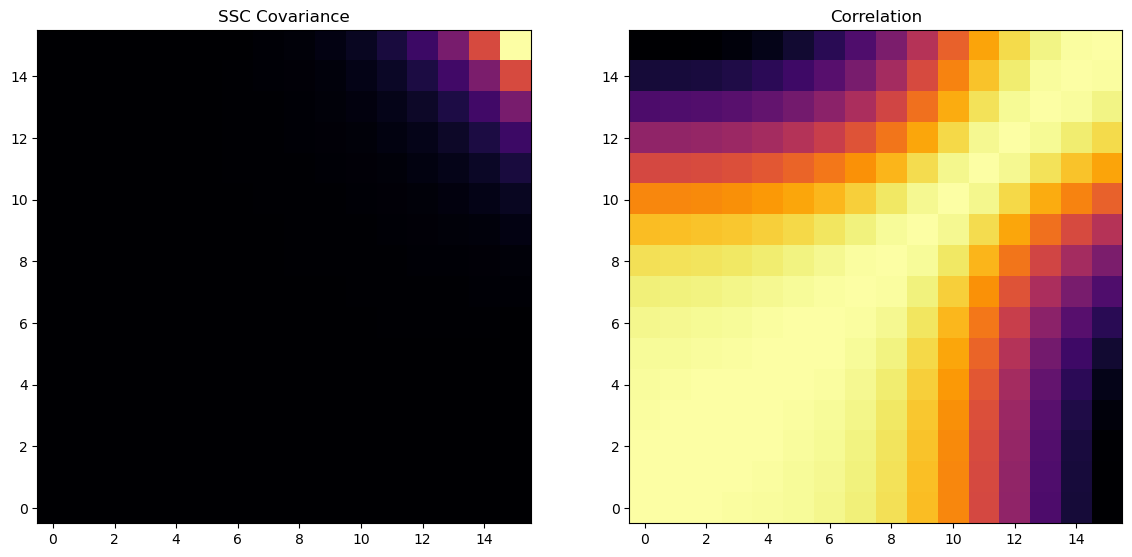

In [106]:
# Step 5: Compute the SSC covariance
cov_ssc_kk = ccl.covariances.angular_cl_cov_SSC(
    cosmo=cosmo,
    tracer1=lensing_tracer,
    tracer2=lensing_tracer,
    ell=ell_values,
    t_of_kk_a=tk3d,
    sigma2_B=(a_arr, sigma2_B),
    fsky=f_sky
)
# dimensionless
cov_ssc_kk = dimensionless_cov(cov_ssc_kk, ell_values)
var_ssc = np.diag(cov_ssc_kk)
off_diag_1_ssc = np.diag(cov_ssc_kk, k=1)


fig = plt.figure(figsize=(14, 7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.imshow(cov_ssc_kk, origin='lower', cmap='inferno')
ax1.set_title('SSC Covariance')

corr_ssc_kk = cov_ssc_kk / np.sqrt(np.outer(np.diag(cov_ssc_kk), np.diag(cov_ssc_kk)))
ax2.imshow(corr_ssc_kk, origin='lower', cmap='inferno')
ax2.set_title('Correlation')
plt.show()

In [107]:
# Step 6: Compute the cNG covariance
"""
cov_cng_kk = ccl.covariances.angular_cl_cov_cNG(
    cosmo=cosmo,
    tracer1=lensing_tracer,
    tracer2=lensing_tracer,
    ell=ell_values,
    t_of_kk_a=tk3d,
    fsky=f_sky
)
"""

'\ncov_cng_kk = ccl.covariances.angular_cl_cov_cNG(\n    cosmo=cosmo,\n    tracer1=lensing_tracer,\n    tracer2=lensing_tracer,\n    ell=ell_values,\n    t_of_kk_a=tk3d,\n    fsky=f_sky\n)\n'

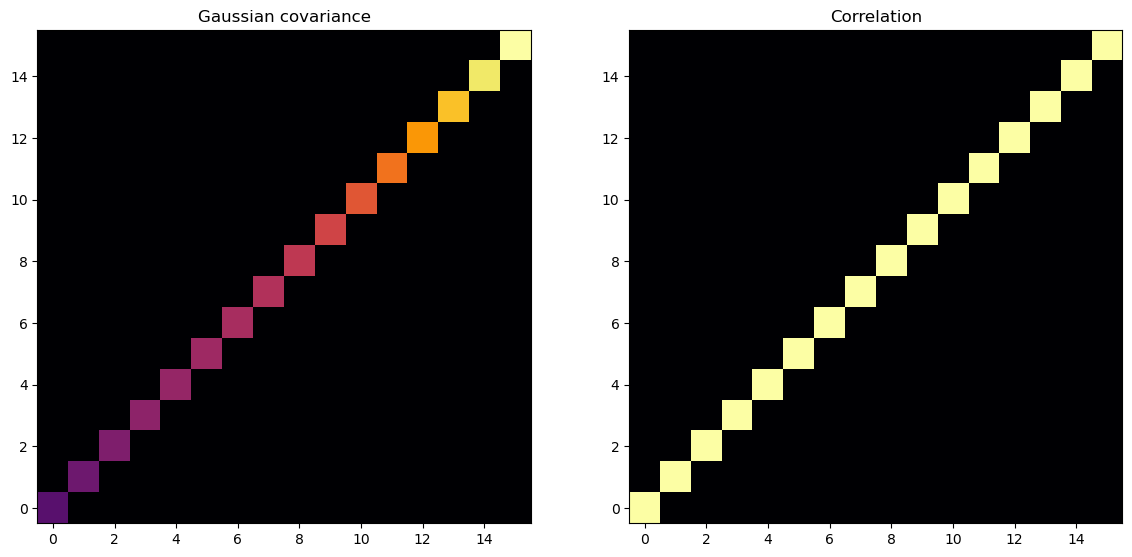

In [108]:
# Step 7: Compute the Gaussian covariance
cl_kk = ccl.angular_cl(
    cosmo=cosmo,
    tracer1=lensing_tracer,
    tracer2=lensing_tracer,
    ell=ell_values)
cov_kk_kk = np.zeros((len(ell_values), len(ell_values)))
for i, ell in enumerate(ell_values):
    cov_kk_kk[i, i] = (1 / ((2 * ell + 1) * f_sky)) * (
        2 * cl_kk[i]**2  
    )
# dimensionless
cov_kk_kk = dimensionless_cov(cov_kk_kk, ell_values)
var_gaussian = np.diag(cov_kk_kk)


fig = plt.figure(figsize=(14, 7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.imshow(cov_kk_kk, origin='lower', cmap='inferno')
ax1.set_title('Gaussian covariance')

corr_kk_kk = cov_kk_kk / np.sqrt(np.outer(np.diag(cov_kk_kk), np.diag(cov_kk_kk)))
ax2.imshow(corr_kk_kk, origin='lower', cmap='inferno')
ax2.set_title('Correlation')
plt.show()

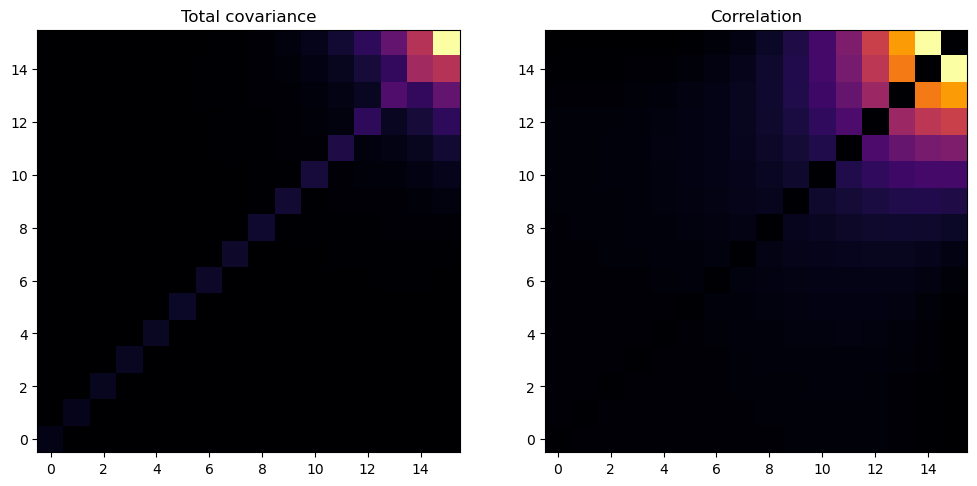

In [110]:
# Step 8: Plot the results
total_cov = cov_ssc_kk + cov_kk_kk
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(total_cov, origin='lower', cmap='inferno')
ax[0].set_title('Total covariance')

corr = total_cov / np.sqrt(np.diag(total_cov)[:, None] * np.diag(total_cov)[None, :])
np.fill_diagonal(corr, 0)
ax[1].imshow(corr, origin='lower', cmap='inferno')
ax[1].set_title('Correlation')
plt.show()

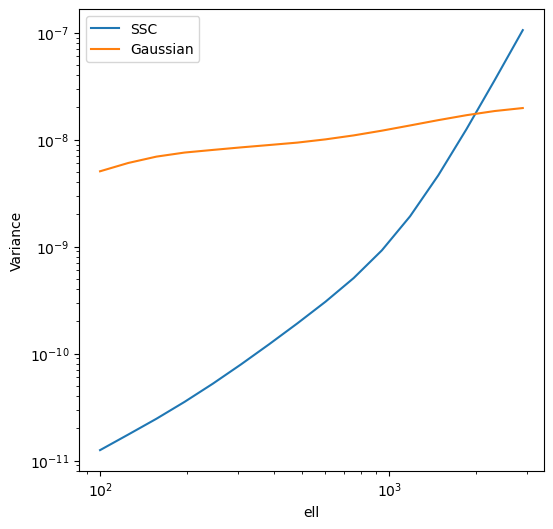

In [111]:
# plot the diagonal of the covariance matrix
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(ell_values,var_ssc, label='SSC')
ax.plot(ell_values,var_gaussian, label='Gaussian')
ax.set_xlabel('ell')
ax.set_ylabel('Variance')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
plt.show()


In [92]:
import itertools

# test cov_ssc_kk for all combinations of z_source, lmin, lmax, f_sky
z_source_list = [0.5, 1.0, 2.0, 3.0]
lmin_list = [20, 50, 100]
lmax_list = [500, 1000, 3000]
f_sky_list = [1/50, 1/20, 1/10]


bad_list = []
for z_source, lmin, lmax, f_sky in itertools.product(z_source_list, lmin_list, lmax_list, f_sky_list):
    lensing_tracer = ccl.CMBLensingTracer(cosmo, z_source=z_source)
    sigma2_B = ccl.sigma2_B_disc(cosmo, a_arr=a_arr, fsky=f_sky)
    ell_values = np.logspace(np.log10(lmin), np.log10(lmax), nbin+1, endpoint=True)
    try:
        cov_ssc_kk = ccl.covariances.angular_cl_cov_SSC(
            cosmo=cosmo,
            tracer1=lensing_tracer,
            tracer2=lensing_tracer,
            ell=ell_values,
            t_of_kk_a=tk3d,
            sigma2_B=(a_arr, sigma2_B),
            fsky=f_sky
        )
        print(f'z_source: {z_source}, lmin: {lmin}, lmax: {lmax}, f_sky: {f_sky}')
        
    except Exception as e:
        #print(f'Error: z_source: {z_source}, lmin: {lmin}, lmax: {lmax}, f_sky: {f_sky}')
        #print(e)
        bad_list.append([z_source, lmin, lmax, f_sky])
        continue

# check fine_list by exclude bad_list from all combinations
fine_list = []
for z_source, lmin, lmax, f_sky in itertools.product(z_source_list, lmin_list, lmax_list, f_sky_list):
    if [z_source, lmin, lmax, f_sky] not in bad_list:
        fine_list.append([z_source, lmin, lmax, f_sky])

print(f'fine_list: {fine_list}')

z_source: 0.5, lmin: 20, lmax: 500, f_sky: 0.02
z_source: 0.5, lmin: 20, lmax: 500, f_sky: 0.05
z_source: 0.5, lmin: 20, lmax: 500, f_sky: 0.1
z_source: 0.5, lmin: 20, lmax: 1000, f_sky: 0.02
z_source: 0.5, lmin: 20, lmax: 1000, f_sky: 0.05
z_source: 0.5, lmin: 20, lmax: 1000, f_sky: 0.1


WARNING 1029: ccl_f1d.c: ccl_f1d_t_eval(): x-value above range.: GSL ERROR: unknown error code
WARNING 5: ccl_cls.c: ccl_angular_cov_limber():: GSL ERROR: generic failure
WARNING 1029: ccl_f1d.c: ccl_f1d_t_eval(): x-value above range.: GSL ERROR: unknown error code
WARNING 5: ccl_cls.c: ccl_angular_cov_limber():: GSL ERROR: generic failure
WARNING 1029: ccl_f1d.c: ccl_f1d_t_eval(): x-value above range.: GSL ERROR: unknown error code
WARNING 5: ccl_cls.c: ccl_angular_cov_limber():: GSL ERROR: generic failure
WARNING 1064: Status message being overwritten:
STATUS: 0. ccl_cls.c: ccl_angular_cov_limber(); integration error

WARNING 1029: ccl_f1d.c: ccl_f1d_t_eval(): x-value above range.: GSL ERROR: unknown error code
WARNING 5: ccl_cls.c: ccl_angular_cov_limber():: GSL ERROR: generic failure
WARNING 1029: ccl_f1d.c: ccl_f1d_t_eval(): x-value above range.: GSL ERROR: unknown error code
WARNING 5: ccl_cls.c: ccl_angular_cov_limber():: GSL ERROR: generic failure
WARNING 1029: ccl_f1d.c: ccl_f

z_source: 0.5, lmin: 50, lmax: 500, f_sky: 0.02
z_source: 0.5, lmin: 50, lmax: 500, f_sky: 0.05
z_source: 0.5, lmin: 50, lmax: 500, f_sky: 0.1
z_source: 0.5, lmin: 50, lmax: 1000, f_sky: 0.02
z_source: 0.5, lmin: 50, lmax: 1000, f_sky: 0.05
z_source: 0.5, lmin: 50, lmax: 1000, f_sky: 0.1
z_source: 0.5, lmin: 100, lmax: 500, f_sky: 0.02
z_source: 0.5, lmin: 100, lmax: 500, f_sky: 0.05
z_source: 0.5, lmin: 100, lmax: 500, f_sky: 0.1
z_source: 0.5, lmin: 100, lmax: 1000, f_sky: 0.02
z_source: 0.5, lmin: 100, lmax: 1000, f_sky: 0.05
z_source: 0.5, lmin: 100, lmax: 1000, f_sky: 0.1


WARNING 1029: ccl_f1d.c: ccl_f1d_t_eval(): x-value above range.: GSL ERROR: unknown error code
WARNING 5: ccl_cls.c: ccl_angular_cov_limber():: GSL ERROR: generic failure
WARNING 1029: ccl_f1d.c: ccl_f1d_t_eval(): x-value above range.: GSL ERROR: unknown error code
WARNING 5: ccl_cls.c: ccl_angular_cov_limber():: GSL ERROR: generic failure
WARNING 1064: Status message being overwritten:
STATUS: 0. ccl_cls.c: ccl_angular_cov_limber(); integration error

WARNING 1029: ccl_f1d.c: ccl_f1d_t_eval(): x-value above range.: GSL ERROR: unknown error code
WARNING 5: ccl_cls.c: ccl_angular_cov_limber():: GSL ERROR: generic failure
WARNING 1029: ccl_f1d.c: ccl_f1d_t_eval(): x-value above range.: GSL ERROR: unknown error code
WARNING 5: ccl_cls.c: ccl_angular_cov_limber():: GSL ERROR: generic failure
WARNING 1064: Status message being overwritten:
STATUS: 0. ccl_cls.c: ccl_angular_cov_limber(); integration error

WARNING 1029: ccl_f1d.c: ccl_f1d_t_eval(): x-value above range.: GSL ERROR: unknown er

z_source: 1.0, lmin: 20, lmax: 500, f_sky: 0.02
z_source: 1.0, lmin: 20, lmax: 500, f_sky: 0.05
z_source: 1.0, lmin: 20, lmax: 500, f_sky: 0.1
z_source: 1.0, lmin: 20, lmax: 1000, f_sky: 0.02
z_source: 1.0, lmin: 20, lmax: 1000, f_sky: 0.05
z_source: 1.0, lmin: 20, lmax: 1000, f_sky: 0.1


WARNING 1029: ccl_f1d.c: ccl_f1d_t_eval(): x-value above range.: GSL ERROR: unknown error code
WARNING 5: ccl_cls.c: ccl_angular_cov_limber():: GSL ERROR: generic failure
WARNING 1064: Status message being overwritten:
STATUS: 0. ccl_cls.c: ccl_angular_cov_limber(); integration error

WARNING 1029: ccl_f1d.c: ccl_f1d_t_eval(): x-value above range.: GSL ERROR: unknown error code
WARNING 5: ccl_cls.c: ccl_angular_cov_limber():: GSL ERROR: generic failure
WARNING 1064: Status message being overwritten:
STATUS: 0. ccl_cls.c: ccl_angular_cov_limber(); integration error

WARNING 1029: ccl_f1d.c: ccl_f1d_t_eval(): x-value above range.: GSL ERROR: unknown error code
WARNING 5: ccl_cls.c: ccl_angular_cov_limber():: GSL ERROR: generic failure
WARNING 1064: Status message being overwritten:
STATUS: 0. ccl_cls.c: ccl_angular_cov_limber(); integration error



z_source: 1.0, lmin: 50, lmax: 500, f_sky: 0.02
z_source: 1.0, lmin: 50, lmax: 500, f_sky: 0.05
z_source: 1.0, lmin: 50, lmax: 500, f_sky: 0.1
z_source: 1.0, lmin: 50, lmax: 1000, f_sky: 0.02
z_source: 1.0, lmin: 50, lmax: 1000, f_sky: 0.05
z_source: 1.0, lmin: 50, lmax: 1000, f_sky: 0.1
z_source: 1.0, lmin: 50, lmax: 3000, f_sky: 0.02
z_source: 1.0, lmin: 50, lmax: 3000, f_sky: 0.05
z_source: 1.0, lmin: 50, lmax: 3000, f_sky: 0.1
z_source: 1.0, lmin: 100, lmax: 500, f_sky: 0.02
z_source: 1.0, lmin: 100, lmax: 500, f_sky: 0.05
z_source: 1.0, lmin: 100, lmax: 500, f_sky: 0.1
z_source: 1.0, lmin: 100, lmax: 1000, f_sky: 0.02
z_source: 1.0, lmin: 100, lmax: 1000, f_sky: 0.05
z_source: 1.0, lmin: 100, lmax: 1000, f_sky: 0.1


WARNING 1029: ccl_f1d.c: ccl_f1d_t_eval(): x-value above range.: GSL ERROR: unknown error code
WARNING 5: ccl_cls.c: ccl_angular_cov_limber():: GSL ERROR: generic failure
WARNING 1064: Status message being overwritten:
STATUS: 0. ccl_cls.c: ccl_angular_cov_limber(); integration error

WARNING 1029: ccl_f1d.c: ccl_f1d_t_eval(): x-value above range.: GSL ERROR: unknown error code
WARNING 5: ccl_cls.c: ccl_angular_cov_limber():: GSL ERROR: generic failure
WARNING 1064: Status message being overwritten:
STATUS: 0. ccl_cls.c: ccl_angular_cov_limber(); integration error

WARNING 1029: ccl_f1d.c: ccl_f1d_t_eval(): x-value above range.: GSL ERROR: unknown error code
WARNING 5: ccl_cls.c: ccl_angular_cov_limber():: GSL ERROR: generic failure
WARNING 1064: Status message being overwritten:
STATUS: 0. ccl_cls.c: ccl_angular_cov_limber(); integration error



z_source: 2.0, lmin: 20, lmax: 500, f_sky: 0.02
z_source: 2.0, lmin: 20, lmax: 500, f_sky: 0.05
z_source: 2.0, lmin: 20, lmax: 500, f_sky: 0.1
z_source: 2.0, lmin: 20, lmax: 1000, f_sky: 0.02
z_source: 2.0, lmin: 20, lmax: 1000, f_sky: 0.05
z_source: 2.0, lmin: 20, lmax: 1000, f_sky: 0.1
z_source: 2.0, lmin: 20, lmax: 3000, f_sky: 0.02
z_source: 2.0, lmin: 20, lmax: 3000, f_sky: 0.05
z_source: 2.0, lmin: 20, lmax: 3000, f_sky: 0.1
z_source: 2.0, lmin: 50, lmax: 500, f_sky: 0.02
z_source: 2.0, lmin: 50, lmax: 500, f_sky: 0.05
z_source: 2.0, lmin: 50, lmax: 500, f_sky: 0.1
z_source: 2.0, lmin: 50, lmax: 1000, f_sky: 0.02
z_source: 2.0, lmin: 50, lmax: 1000, f_sky: 0.05
z_source: 2.0, lmin: 50, lmax: 1000, f_sky: 0.1
z_source: 2.0, lmin: 50, lmax: 3000, f_sky: 0.02
z_source: 2.0, lmin: 50, lmax: 3000, f_sky: 0.05
z_source: 2.0, lmin: 50, lmax: 3000, f_sky: 0.1
z_source: 2.0, lmin: 100, lmax: 500, f_sky: 0.02
z_source: 2.0, lmin: 100, lmax: 500, f_sky: 0.05
z_source: 2.0, lmin: 100, lmax: 

WARNING 1029: ccl_f1d.c: ccl_f1d_t_eval(): x-value above range.: GSL ERROR: unknown error code
WARNING 5: ccl_cls.c: ccl_angular_cov_limber():: GSL ERROR: generic failure
WARNING 1064: Status message being overwritten:
STATUS: 0. ccl_cls.c: ccl_angular_cov_limber(); integration error

WARNING 1029: ccl_f1d.c: ccl_f1d_t_eval(): x-value above range.: GSL ERROR: unknown error code
WARNING 5: ccl_cls.c: ccl_angular_cov_limber():: GSL ERROR: generic failure
WARNING 1064: Status message being overwritten:
STATUS: 0. ccl_cls.c: ccl_angular_cov_limber(); integration error

WARNING 1029: ccl_f1d.c: ccl_f1d_t_eval(): x-value above range.: GSL ERROR: unknown error code
WARNING 5: ccl_cls.c: ccl_angular_cov_limber():: GSL ERROR: generic failure
WARNING 1064: Status message being overwritten:
STATUS: 0. ccl_cls.c: ccl_angular_cov_limber(); integration error



z_source: 3.0, lmin: 20, lmax: 500, f_sky: 0.02
z_source: 3.0, lmin: 20, lmax: 500, f_sky: 0.05
z_source: 3.0, lmin: 20, lmax: 500, f_sky: 0.1
z_source: 3.0, lmin: 20, lmax: 1000, f_sky: 0.02
z_source: 3.0, lmin: 20, lmax: 1000, f_sky: 0.05
z_source: 3.0, lmin: 20, lmax: 1000, f_sky: 0.1
z_source: 3.0, lmin: 20, lmax: 3000, f_sky: 0.02
z_source: 3.0, lmin: 20, lmax: 3000, f_sky: 0.05
z_source: 3.0, lmin: 20, lmax: 3000, f_sky: 0.1
z_source: 3.0, lmin: 50, lmax: 500, f_sky: 0.02
z_source: 3.0, lmin: 50, lmax: 500, f_sky: 0.05
z_source: 3.0, lmin: 50, lmax: 500, f_sky: 0.1
z_source: 3.0, lmin: 50, lmax: 1000, f_sky: 0.02
z_source: 3.0, lmin: 50, lmax: 1000, f_sky: 0.05
z_source: 3.0, lmin: 50, lmax: 1000, f_sky: 0.1
z_source: 3.0, lmin: 50, lmax: 3000, f_sky: 0.02
z_source: 3.0, lmin: 50, lmax: 3000, f_sky: 0.05
z_source: 3.0, lmin: 50, lmax: 3000, f_sky: 0.1
z_source: 3.0, lmin: 100, lmax: 500, f_sky: 0.02
z_source: 3.0, lmin: 100, lmax: 500, f_sky: 0.05
z_source: 3.0, lmin: 100, lmax: 

WARNING 1029: ccl_f1d.c: ccl_f1d_t_eval(): x-value above range.: GSL ERROR: unknown error code
WARNING 5: ccl_cls.c: ccl_angular_cov_limber():: GSL ERROR: generic failure
WARNING 1064: Status message being overwritten:
STATUS: 0. ccl_cls.c: ccl_angular_cov_limber(); integration error

WARNING 1029: ccl_f1d.c: ccl_f1d_t_eval(): x-value above range.: GSL ERROR: unknown error code
WARNING 5: ccl_cls.c: ccl_angular_cov_limber():: GSL ERROR: generic failure
WARNING 1064: Status message being overwritten:
STATUS: 0. ccl_cls.c: ccl_angular_cov_limber(); integration error

WARNING 1029: ccl_f1d.c: ccl_f1d_t_eval(): x-value above range.: GSL ERROR: unknown error code
WARNING 5: ccl_cls.c: ccl_angular_cov_limber():: GSL ERROR: generic failure
WARNING 1064: Status message being overwritten:
STATUS: 0. ccl_cls.c: ccl_angular_cov_limber(); integration error



In [93]:
# test cov_ssc_kk for all combinations of z_source, lmin, lmax, f_sky
z_source_list = [0.5, 1.0, 2.0, 3.0]
lmin_list = [20, 50, 100]
lmax_list = [500, 1000, 3000]
f_sky_list = [1/50, 1/20, 1/10]


bad_list = []
for z_source, lmin, lmax, f_sky in itertools.product(z_source_list, lmin_list, lmax_list, f_sky_list):
    lensing_tracer = ccl.CMBLensingTracer(cosmo, z_source=z_source)
    ell_values = np.logspace(np.log10(lmin), np.log10(lmax), nbin+1, endpoint=True)
    try:
        cov_cng_kk = ccl.covariances.angular_cl_cov_cNG(
            cosmo=cosmo,
            tracer1=lensing_tracer,
            tracer2=lensing_tracer,
            ell=ell_values,
            t_of_kk_a=tk3d,
            fsky=f_sky
        )
        print(f'z_source: {z_source}, lmin: {lmin}, lmax: {lmax}, f_sky: {f_sky}')
        
    except Exception as e:
        #print(f'Error: z_source: {z_source}, lmin: {lmin}, lmax: {lmax}, f_sky: {f_sky}')
        #print(e)
        bad_list.append([z_source, lmin, lmax, f_sky])
        continue

# check fine_list by exclude bad_list from all combinations
fine_list = []
for z_source, lmin, lmax, f_sky in itertools.product(z_source_list, lmin_list, lmax_list, f_sky_list):
    if [z_source, lmin, lmax, f_sky] not in bad_list:
        fine_list.append([z_source, lmin, lmax, f_sky])

print(f'fine_list: {fine_list}')

WARNING 5: ccl_cls.c: ccl_angular_cov_limber():: GSL ERROR: generic failure
WARNING 5: ccl_cls.c: ccl_angular_cov_limber():: GSL ERROR: generic failure
WARNING 5: ccl_cls.c: ccl_angular_cov_limber():: GSL ERROR: generic failure
WARNING 5: ccl_cls.c: ccl_angular_cov_limber():: GSL ERROR: generic failure
WARNING 5: ccl_cls.c: ccl_angular_cov_limber():: GSL ERROR: generic failure
WARNING 5: ccl_cls.c: ccl_angular_cov_limber():: GSL ERROR: generic failure
WARNING 5: ccl_cls.c: ccl_angular_cov_limber():: GSL ERROR: generic failure
WARNING 5: ccl_cls.c: ccl_angular_cov_limber():: GSL ERROR: generic failure
WARNING 5: ccl_cls.c: ccl_angular_cov_limber():: GSL ERROR: generic failure
WARNING 5: ccl_cls.c: ccl_angular_cov_limber():: GSL ERROR: generic failure
WARNING 5: ccl_cls.c: ccl_angular_cov_limber():: GSL ERROR: generic failure
WARNING 1064: Status message being overwritten:
STATUS: 0. ccl_cls.c: ccl_angular_cov_limber(); integration error

WARNING 5: ccl_cls.c: ccl_angular_cov_limber():: 

fine_list: []


RROR: generic failure
WARNING 5: ccl_cls.c: ccl_angular_cov_limber():: GSL ERROR: generic failure
WARNING 1064: Status message being overwritten:
STATUS: 0. ccl_cls.c: ccl_angular_cov_limber(); integration error

WARNING 5: ccl_cls.c: ccl_angular_cov_limber():: GSL ERROR: generic failure
WARNING 5: ccl_cls.c: ccl_angular_cov_limber():: GSL ERROR: generic failure
WARNING 5: ccl_cls.c: ccl_angular_cov_limber():: GSL ERROR: generic failure
WARNING 5: ccl_cls.c: ccl_angular_cov_limber():: GSL ERROR: generic failure
WARNING 5: ccl_cls.c: ccl_angular_cov_limber():: GSL ERROR: generic failure
WARNING 5: ccl_cls.c: ccl_angular_cov_limber():: GSL ERROR: generic failure
WARNING 5: ccl_cls.c: ccl_angular_cov_limber():: GSL ERROR: generic failure
WARNING 5: ccl_cls.c: ccl_angular_cov_limber():: GSL ERROR: generic failure
WARNING 5: ccl_cls.c: ccl_angular_cov_limber():: GSL ERROR: generic failure
WARNING 5: ccl_cls.c: ccl_angular_cov_limber():: GSL ERROR: generic failure
WARNING 5: ccl_cls.c: ccl_a

# WL tracer

In [112]:
import os

data_dir = '/Users/akiratokiwa/workspace/LSSC/notebook'
z, nofz = np.loadtxt(os.path.join(data_dir, "ssc_WL_nofz.txt"),unpack=True)

In [113]:
WL_tracer = ccl.WeakLensingTracer(cosmo, dndz=(z, nofz))

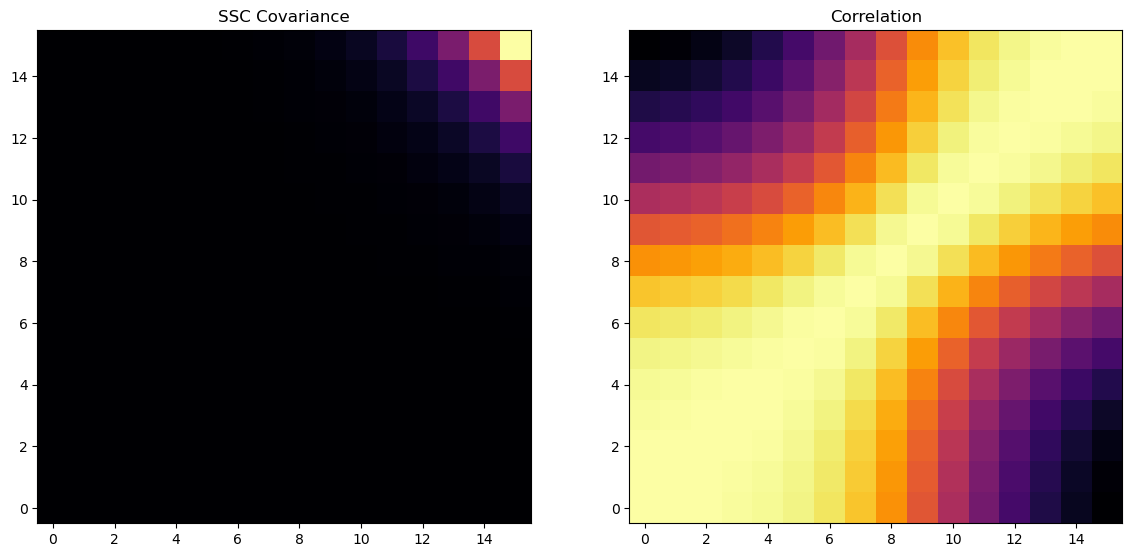

In [114]:
cov_ssc_kk = ccl.covariances.angular_cl_cov_SSC(
    cosmo=cosmo,
    tracer1=WL_tracer,
    tracer2=WL_tracer,
    ell=ell_values,
    t_of_kk_a=tk3d,
    sigma2_B=(a_arr, sigma2_B),
    fsky=f_sky
)
# dimensionless
cov_ssc_kk = dimensionless_cov(cov_ssc_kk, ell_values)
var_ssc = np.diag(cov_ssc_kk)
off_diag_1_ssc = np.diag(cov_ssc_kk, k=1)


fig = plt.figure(figsize=(14, 7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.imshow(cov_ssc_kk, origin='lower', cmap='inferno')
ax1.set_title('SSC Covariance')

corr_ssc_kk = cov_ssc_kk / np.sqrt(np.outer(np.diag(cov_ssc_kk), np.diag(cov_ssc_kk)))
ax2.imshow(corr_ssc_kk, origin='lower', cmap='inferno')
ax2.set_title('Correlation')
plt.show()

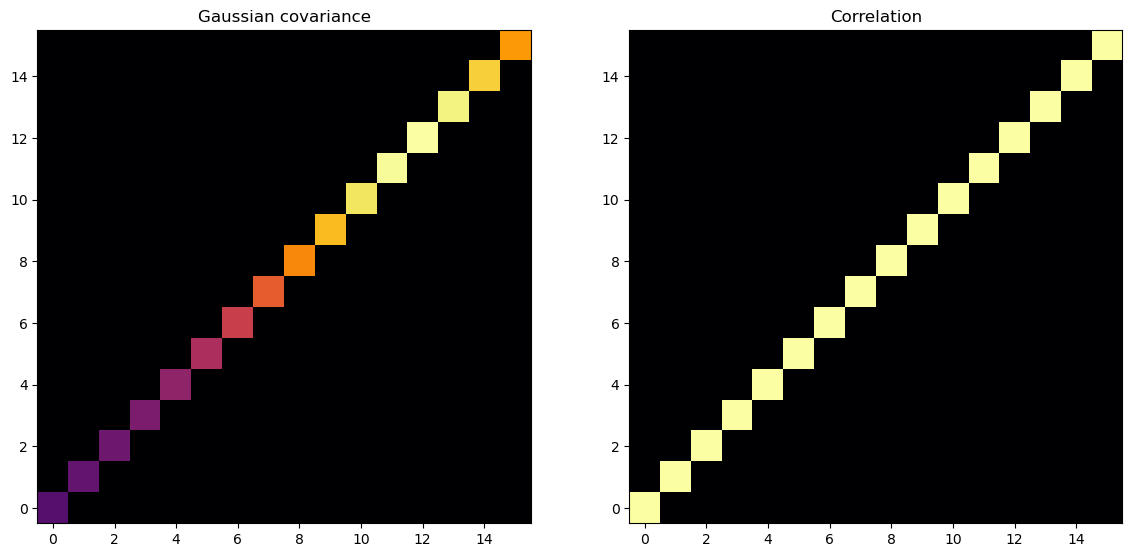

In [115]:
cl_kk = ccl.angular_cl(
    cosmo=cosmo,
    tracer1=WL_tracer,
    tracer2=WL_tracer,
    ell=ell_values)
cov_kk_kk = np.zeros((len(ell_values), len(ell_values)))
for i, ell in enumerate(ell_values):
    cov_kk_kk[i, i] = (1 / ((2 * ell + 1) * f_sky)) * (
        2 * cl_kk[i]**2  
    )
# dimensionless
cov_kk_kk = dimensionless_cov(cov_kk_kk, ell_values)
var_gaussian = np.diag(cov_kk_kk)
off_diag_1_gaussian = np.diag(cov_kk_kk, k=1)

fig = plt.figure(figsize=(14, 7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.imshow(cov_kk_kk, origin='lower', cmap='inferno')
ax1.set_title('Gaussian covariance')

corr_kk_kk = cov_kk_kk / np.sqrt(np.outer(np.diag(cov_kk_kk), np.diag(cov_kk_kk)))
ax2.imshow(corr_kk_kk, origin='lower', cmap='inferno')
ax2.set_title('Correlation')
plt.show()

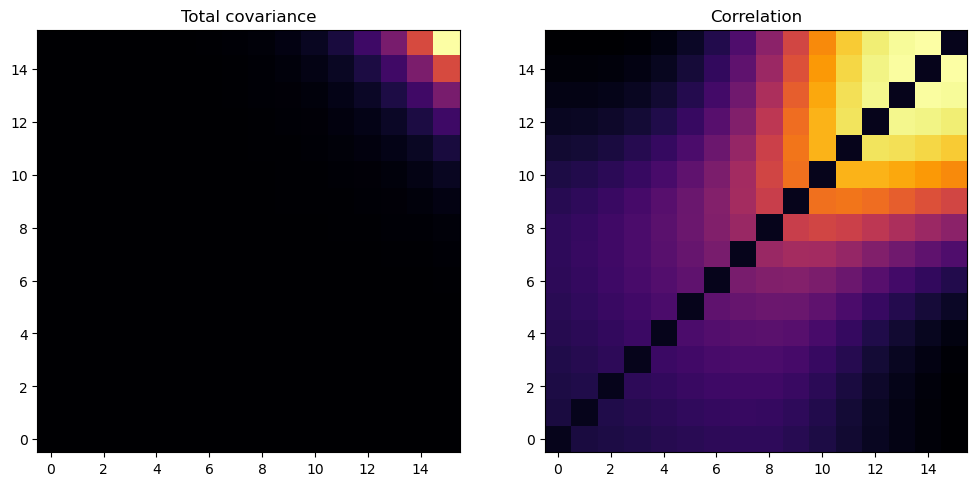

In [116]:
total_cov = cov_ssc_kk + cov_kk_kk
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(total_cov, origin='lower', cmap='inferno')
ax[0].set_title('Total covariance')

corr = total_cov / np.sqrt(np.diag(total_cov)[:, None] * np.diag(total_cov)[None, :])
np.fill_diagonal(corr, 0)
ax[1].imshow(corr, origin='lower', cmap='inferno')
ax[1].set_title('Correlation')
plt.show()

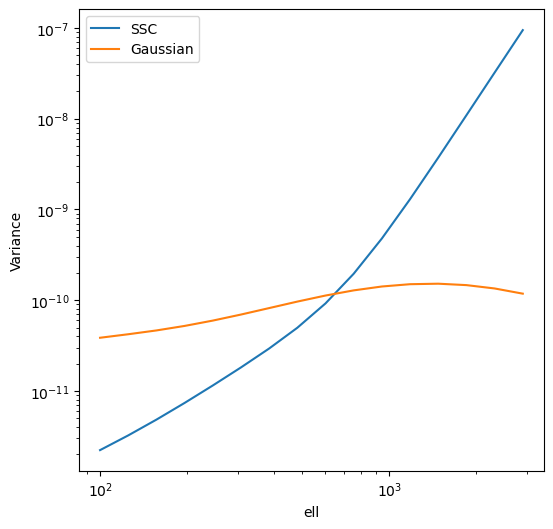

In [117]:
# plot the diagonal of the covariance matrix
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(ell_values,var_ssc, label='SSC')
ax.plot(ell_values,var_gaussian, label='Gaussian')
ax.set_xlabel('ell')
ax.set_ylabel('Variance')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
plt.show()

# clkk

In [127]:
clkks = []
lmin, lmax = 300, 3000  # Example ell range
nbin = 15  # Example number of ell bins
ell_values = np.logspace(np.log10(lmin), np.log10(lmax), nbin+1, endpoint=True)  # Example ell values
zs_list = [0.5, 1.0, 2.0, 3.0]

for z_source in zs_list:
    lensing_tracer = ccl.CMBLensingTracer(cosmo, z_source=z_source)
    cl_kk_gaussian = ccl.angular_cl(
        cosmo=cosmo,
        tracer1=lensing_tracer,
        tracer2=lensing_tracer,
        ell=ell_values)
    cl_kk_gaussian = dimensionless_cl(cl_kk_gaussian, ell_values)
    clkks.append(cl_kk_gaussian)

<>:5: SyntaxWarning: invalid escape sequence '\e'
<>:6: SyntaxWarning: invalid escape sequence '\e'
<>:5: SyntaxWarning: invalid escape sequence '\e'
<>:6: SyntaxWarning: invalid escape sequence '\e'
/var/folders/0d/8g1xn5h16zsbw0q1yz0mr9dr0000gn/T/ipykernel_80256/1006394073.py:5: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\ell$', fontsize=22)
/var/folders/0d/8g1xn5h16zsbw0q1yz0mr9dr0000gn/T/ipykernel_80256/1006394073.py:6: SyntaxWarning: invalid escape sequence '\e'
  plt.ylabel('$C_{\ell}$', fontsize=22)


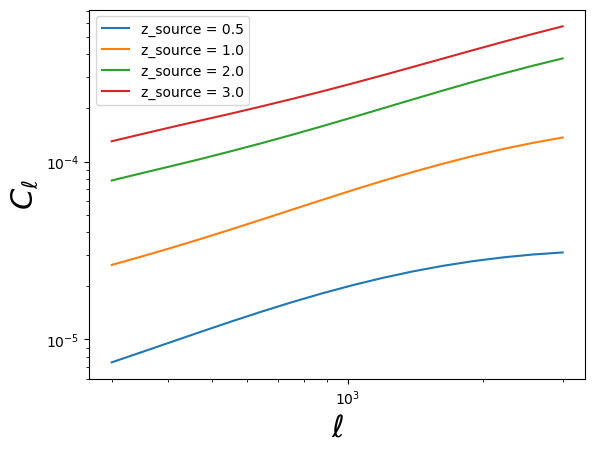

In [128]:
for i, z_source in enumerate(zs_list):
    plt.plot(ell_values, clkks[i], label=f'z_source = {z_source}')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\ell$', fontsize=22)
plt.ylabel('$C_{\ell}$', fontsize=22)
plt.legend()
plt.show()